# **シンプルなブレンディングを試してみる**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['year'] = input_data['datetime'].map(lambda x: int(x.year))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [4]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [5]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [6]:
def scaling_output(output_30):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [7]:
def to_zero(prediction):
    '''
    2012年から2015年の間で一度も発電量がなかった時間帯を0と予測するようにする
    '''
    mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,0,0,0,0,0,0,0,0,0,0])
    all_mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,0,0,0,0,0,0,0,0,0,0])
    length = int(len(prediction)/48)
    
    for i in range(length-1):
        all_mask = np.r_[all_mask, mask]
    
    return prediction * all_mask

In [88]:
def to_zero_df(train_prediction):
    '''
    発電しない時間帯を全て0にする
    '''
    for column in train_prediction.columns[1:]:
        tmp = train_prediction[column]
        tmp = np.array(tmp)
        tmp = to_zero(tmp)
        train_prediction[column] = tmp
    return train_prediction

In [8]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [9]:
n_estimators = 20
max_depth = 5
max_features = "sqrt"

In [10]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **浮島発電所について**

In [142]:
target_place = 1

In [143]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [144]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [145]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [146]:
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [147]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [148]:
len(train_prediction.columns), len(test_prediction.columns)

(39, 39)

In [149]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [150]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [151]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [155]:
# 最適な深さを決める

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

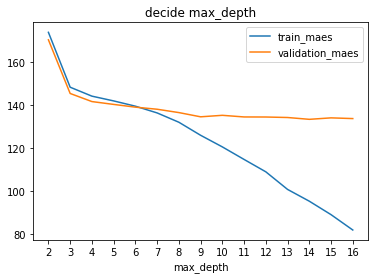

In [157]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [158]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 14, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

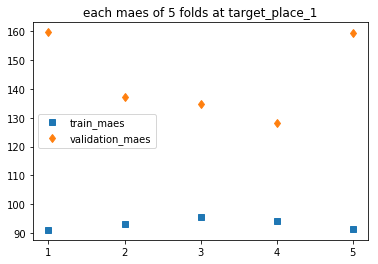

In [159]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [160]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 14, max_features=max_features)

rf.fit(X, Y)
Y_train_pred = rf.predict(X)
print("train_mae : ", np.abs(Y_train_pred - Y).mean())

train_mae :  96.4282889785


In [161]:
Y_test_pred = rf.predict(X_test)

In [162]:
s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
predict_data.index = np.arange(len(predict_data))

In [163]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島発電所について**

In [164]:
target_place = 2

In [165]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [166]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [167]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [168]:
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [169]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [170]:
len(train_prediction.columns), len(test_prediction.columns)

(39, 39)

In [171]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [172]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [173]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [174]:
train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

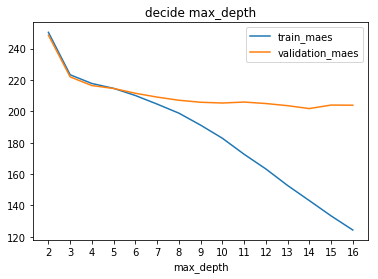

In [175]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [176]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 14, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

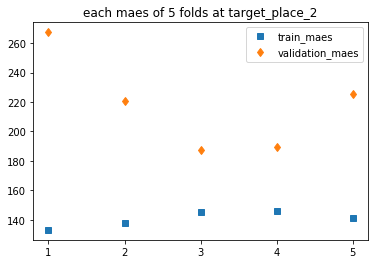

In [177]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [178]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = 10, max_depth = 14, max_features=max_features)
rf.fit(X, Y)
Y_train_pred = rf.predict(X)
print("train_mae : ", np.abs(Y_train_pred - Y).mean())

train_mae :  148.749345464


In [179]:
Y_test_pred = rf.predict(X_test)

In [180]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山発電所について**

In [181]:
target_place = 3

In [182]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [183]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [184]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [185]:
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [186]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [187]:
len(train_prediction.columns), len(train_prediction.columns)

(39, 39)

In [188]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [189]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [190]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [191]:
train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

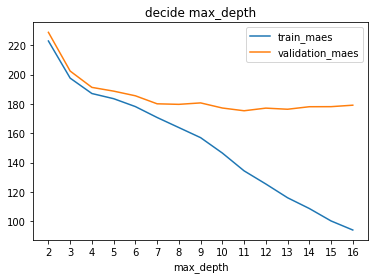

In [192]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [193]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 11, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

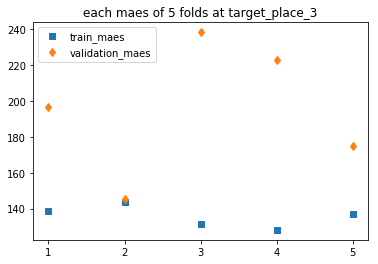

In [194]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [195]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 11, max_features=max_features)
rf.fit(X, Y)
Y_train_pred = rf.predict(X)
print("train_mae : ", np.abs(Y_train_pred - Y).mean())

train_mae :  140.166539015


In [196]:
Y_test_pred = rf.predict(X_test)

In [197]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [198]:
# 発電しない時間帯を0にする
predict_data = to_zero_df(predict_data)

In [199]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)

### 線形モデルでやってみる

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

### **浮島**

In [70]:
target_place = 1

In [91]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [93]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [94]:
train_prediction.columns

Index(['datetime',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_1_limited_scaled

In [95]:
test_prediction.columns

Index(['datetime',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_1_limited_scaled

In [96]:
'''
train_prediction["month"] = train_prediction["datetime"].map(lambda x :str(x.month))
train_prediction["hour"] = train_prediction["datetime"].map(lambda x : str(x.hour))
test_prediction["month"] = test_prediction["datetime"].map(lambda x :str(x.month))
test_prediction["hour"] = test_prediction["datetime"].map(lambda x :str(x.hour))

train_prediction =pd.get_dummies(train_prediction)
test_prediction =pd.get_dummies(test_prediction)
'''

'\ntrain_prediction["month"] = train_prediction["datetime"].map(lambda x :str(x.month))\ntrain_prediction["hour"] = train_prediction["datetime"].map(lambda x : str(x.hour))\ntest_prediction["month"] = test_prediction["datetime"].map(lambda x :str(x.month))\ntest_prediction["hour"] = test_prediction["datetime"].map(lambda x :str(x.hour))\n\ntrain_prediction =pd.get_dummies(train_prediction)\ntest_prediction =pd.get_dummies(test_prediction)\n'

In [97]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [98]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [101]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

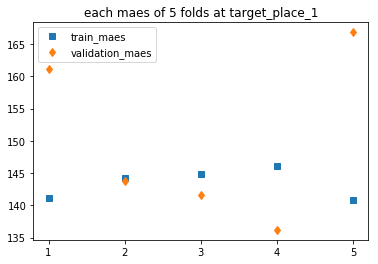

In [102]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [88]:
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X, Y)
# Y_train_pred = lin_model.predict(X)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [89]:
Y_test_pred = lin_model.predict(X_test)

In [90]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島**

In [39]:
target_place = 2

In [40]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [41]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [42]:
train_prediction.columns

Index(['datetime',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds'],
      dtype='object')

In [43]:
test_prediction.columns

Index(['datetime',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds'],
      dtype='object')

In [44]:
len(train_prediction.columns), len(test_prediction.columns)

(9, 9)

In [45]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [46]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [47]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

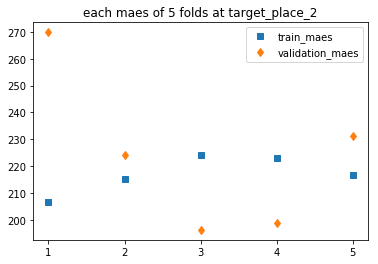

In [48]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [49]:
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X, Y)
# Y_train_pred = lin_model.predict(X)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [50]:
Y_test_pred = lin_model.predict(X_test)

In [51]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山**

In [52]:
target_place = 3

In [53]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [54]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [55]:
train_prediction.columns

Index(['datetime',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds'],
      dtype='object')

In [56]:
test_prediction.columns

Index(['datetime',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds'],
      dtype='object')

In [57]:
len(train_prediction.columns), len(test_prediction.columns)

(9, 9)

In [58]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [59]:
X, Y = drop_nan(X, Y)
X = np.array(X)
Y = np.array(Y)

In [60]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    lin_model = linear_model.LinearRegression(fit_intercept=False)
    lin_model.fit(X_train, Y_train)
    Y_train_pred = lin_model.predict(X_train)
    Y_val_pred = lin_model.predict(X_val)
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

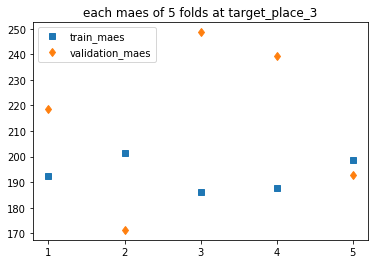

In [61]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [62]:
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X, Y)
# Y_train_pred = lin_model.predict(X)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [63]:
Y_test_pred = lin_model.predict(X_test)

In [64]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [65]:
predict_data["blending_1"] = predict_data["blending_1"].map(lambda x: minus_to_zero(x))
predict_data["blending_2"] = predict_data["blending_2"].map(lambda x: minus_to_zero(x))
predict_data["blending_3"] = predict_data["blending_3"].map(lambda x: minus_to_zero(x))

In [66]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)

### **線形モデル(PLS)をつかう**

In [103]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

### **浮島**

In [104]:
target_place = 1

In [105]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [106]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [107]:
train_prediction.columns

Index(['datetime',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_1_limited_scaled

In [108]:
test_prediction.columns

Index(['datetime',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_1_limited_scaled

In [109]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [110]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [111]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [112]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

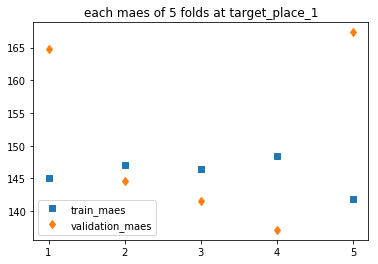

In [113]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [114]:
pls = PLSRegression(n_components = 3)
pls.fit(scaled_X, scaled_Y)
Y_train_pred = Y_scaler.inverse_transform(pls.predict(scaled_X))
print("train mae : ", np.abs(Y_train_pred - Y_scaler.inverse_transform(scaled_Y)).mean())

train mae :  146.193970726


In [115]:
scaled_X_test = X_scaler.transform(X_test)
Y_test_pred = Y_scaler.inverse_transform(pls.predict(scaled_X_test))

In [116]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島**

In [117]:
target_place = 2

In [118]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [119]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [120]:
train_prediction.columns

Index(['datetime',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_2_limited_scaled

In [121]:
test_prediction.columns

Index(['datetime',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_2_limited_scaled

In [122]:
len(train_prediction.columns), len(test_prediction.columns)

(19, 19)

In [123]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [124]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [125]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [126]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

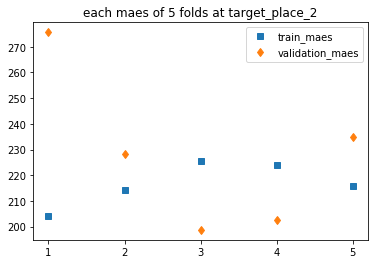

In [127]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [128]:
pls = PLSRegression(n_components = 3)
pls.fit(scaled_X, scaled_Y)
Y_train_pred = Y_scaler.inverse_transform(pls.predict(scaled_X))
print("train mae : ", np.abs(Y_train_pred - Y_scaler.inverse_transform(scaled_Y)).mean())

train mae :  217.153169067


In [129]:
scaled_X_test = X_scaler.transform(X_test)
Y_test_pred = Y_scaler.inverse_transform(pls.predict(scaled_X_test))

In [130]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山**

In [131]:
target_place = 3

In [132]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [133]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [134]:
train_prediction.columns

Index(['datetime',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_3_limited_scaled

In [135]:
test_prediction.columns

Index(['datetime',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_2-5folds',
       'targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_3-5folds',
       'targetplace_3_limited_scaled

In [136]:
len(train_prediction.columns), len(test_prediction.columns)

(19, 19)

In [137]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [138]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [139]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)

In [140]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

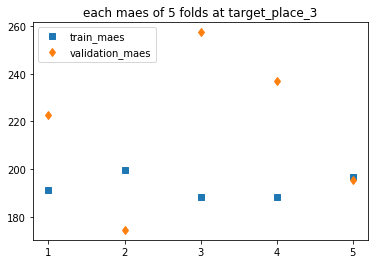

In [141]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [142]:
pls = PLSRegression(n_components = 3)
pls.fit(scaled_X, scaled_Y)
Y_train_pred = Y_scaler.inverse_transform(pls.predict(scaled_X))
print("train mae : ", np.abs(Y_train_pred - Y_scaler.inverse_transform(scaled_Y)).mean())

train mae :  193.636320943


In [143]:
scaled_X_test = X_scaler.transform(X_test)
Y_test_pred = Y_scaler.inverse_transform(pls.predict(scaled_X_test))

In [144]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [109]:
predict_data["blending_1"] = predict_data["blending_1"].map(lambda x: minus_to_zero(x))
predict_data["blending_2"] = predict_data["blending_2"].map(lambda x: minus_to_zero(x))
predict_data["blending_3"] = predict_data["blending_3"].map(lambda x: minus_to_zero(x))

In [110]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)